In [2]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
IMAGES_PATH = os.path.join(".", "data", "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def show_instance(some_digit: np.ndarray, file_name_for_save=None):
    some_digit_image = some_digit.reshape(28, 28)
    plt.imshow(some_digit_image, cmap=mpl.cm.binary)
    plt.axis("off")
    if file_name_for_save:
        save_fig(file_name_for_save)
    plt.show()

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

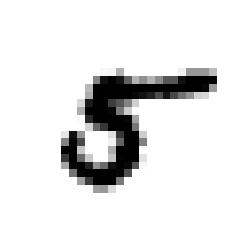

In [5]:
some_digit = X[-2]
show_instance(some_digit)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [8]:
knn_clf.predict([some_digit])

array(['5'], dtype=object)

In [11]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('float_input', FloatTensorType([1, 784]))]
onx = convert_sklearn(knn_clf, initial_types=initial_type)
with open("mnist_knneighbours_classifier.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [10]:
import onnxruntime as rt
sess = rt.InferenceSession("mnist_knneighbours_classifier.onnx")
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
prediction = sess.run([label_name], {input_name: [some_digit.astype(np.float32)]})[0]
int(prediction[0])

5